In [331]:
import  numpy as np
import pandas as pd
import os
import random
import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### Initialise working directories

In [332]:
path = './'

topfile = path+"GLYR_6pm5.prmtop"

dcd_path = path + 'DCDs/'
ligc_directory = 'ligC_coordinates/'
ligc_path = path + ligc_directory
preprocessed_directory = 'processed_ligC_coordinates'
distance_matrix_directory = 'distance_matrix'
preprocessed_path = path + preprocessed_directory
distance_matrix_path = path + distance_matrix_directory

pictures_directory = 'pictures'
pictures_path = path + pictures_directory

if os.path.exists(preprocessed_path)==False:
    os.mkdir(preprocessed_path)
    print("Path '%s' is created!"%preprocessed_directory)
else: 
    print("Path '%s' is already existed!"%preprocessed_directory)
    
if os.path.exists(distance_matrix_path)==False:
    os.mkdir(distance_matrix_path)
    print("Path '%s' is created!"%distance_matrix_directory)
else: 
    print("Path '%s' is already existed!"%distance_matrix_directory)    
    
if os.path.exists(ligc_path)==False:
    os.mkdir(ligc_path)
    print("Path '%s' is created!"%ligc_directory)
else: 
    print("Path '%s' is already existed!"%ligc_directory)    
    
if os.path.exists(pictures_path)==False:
    os.mkdir(pictures_path)
    print("Path '%s' is created!"%pictures_directory)
else: 
    print("Path '%s' is already existed!"%pictures_directory) 

Path 'processed_ligC_coordinates' is already existed!
Path 'distance_matrix' is already existed!
Path 'ligC_coordinates/' is already existed!
Path 'pictures' is already existed!


### Define functions

In [367]:
# 利用高斯距离法计算临近点的权重
# X,Y 模板大小，c 中心点的位置， sigma 影响半径
def gaussion_neighborhood(X,Y,c,sigma):
    xx,yy = np.meshgrid(np.arange(X),np.arange(Y))
    d = 2*sigma*sigma
    ax = np.exp(-np.power(xx-xx.T[c], 2)/d)
    ay = np.exp(-np.power(yy-yy.T[c], 2)/d)
    return (ax * ay).T

# 利用bubble距离法计算临近点的权重
# X,Y 模板大小，c 中心点的位置， sigma 影响半径
def bubble_neighborhood(X,Y,c,sigma):

    neigx = np.arange(X)
    neigY = np.arange(Y)
    
    ax = np.logical_and(neigx > c[0]-sigma,
                     neigx < c[0]+sigma)
    ay = np.logical_and(neigy > c[1]-sigma,
                     neigy < c[1]+sigma)
    return np.outer(ax, ay)*1.

# 计算学习率
def get_learning_rate(lr,t,max_steps):  
    return lr / (1+t/(max_steps/2))

# 计算欧式距离
def euclidean_distance(x, w):
    dis = np.expand_dims(x,axis=(0,1))-w
    return np.linalg.norm(dis, axis=-1)

# 特征标准化 (x-mu)/std
def feature_normalization(data):
    mu = np.mean(data,axis=0,keepdims=True)
    sigma = np.std(data,axis=0,keepdims=True)
    return (data-mu)/sigma

# 获取激活节点的位置
def get_winner_index(x,w,dis_fun=euclidean_distance):
    # 计算输入样本和各个节点的距离
    dis = dis_fun(x,w)
    
    # 找到距离最小的位置
    index = np.where(dis==np.min(dis))
    return (index[0][0],index[1][0])


def weights_PCA(X,Y,data):
    
    N,D = np.shape(data)
    weights = np.zeros([X,Y,D])
    
    pc_length, pc = np.linalg.eig(np.cov(np.transpose(data)))
    pc_order = np.argsort(-pc_length)
    for i, c1 in enumerate(np.linspace(-1, 1, X)):
        for j, c2 in enumerate(np.linspace(-1, 1, Y)):
            weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]
    return weights

# 计算量化误差
def get_quantization_error(datas,weights):
    w_x, w_y = zip(*[get_winner_index(d,weights) for d in datas])
    error = datas - weights[w_x,w_y]
    error = np.linalg.norm(error, axis=-1)
    return np.mean(error)
    
   

def train_SOM(X,
              Y,
              N_epoch,
              datas,
              init_lr = 0.5,
              sigma =0.5,
              dis_fun=euclidean_distance,
              neighborhood_fun=gaussion_neighborhood,
              init_weight_fun = None,
              seed =20):
    
    # 获取输入特征的维度
    N,D = np.shape(datas)
    
    # 训练的步数
    N_steps = N_epoch * N
    
    # 对权重进行初始化
    rng  =  np.random.RandomState(seed)
    if init_weight_fun is None:
        weights = rng.rand(X, Y, D) * 2 - 1
        weights /= np.linalg.norm(weights, axis=-1, keepdims=True)
    else:
        weights = init_weight_fun(X, Y, datas)
    
    # 初始化每个输出单元上的计数
    #unit_counts = np.zeros((X, Y))
    
    # 我们准备返回winner的两个坐标在两个list里面。这样用来画蜂窝图。
    lt_x = []
    lt_y = []
    
    # 存储 quantization_error
    ep_lt = []
    qe_lt = []
 
    for n_epoch in range(N_epoch):
        print("Epoch %d"%(n_epoch+1))
        # 打乱次序
        index = rng.permutation(np.arange(N))
        for n_step,_id in enumerate(index):
            
            # 取一个样本
            x = datas[_id]
            
            # 计算learning rate(eta)
            t = N * n_epoch + n_step
            eta = get_learning_rate(init_lr, t, N_steps)
            
            # 计算样本距离每个顶点的距离,并获得激活点的位置
            winner = get_winner_index(x, weights, dis_fun)
            
            # 根据激活点的位置计算临近点的权重
            new_sigma = get_learning_rate(sigma, t, N_steps)
            g = neighborhood_fun(X, Y, winner, new_sigma)
            g = g * eta
            
            # 更新输出单元上的计数
            #unit_counts[winner] += 1
            # 只更新最后一轮迭代
            if n_epoch == (N_epoch-1):
                lt_x.append(winner[0])
                lt_y.append(winner[1])
            # 进行权重的更新         
            weights = weights + np.expand_dims(g, -1) * (x - weights)
            
        # 打印量化误差
        qe = get_quantization_error(datas, weights)
        print("quantization_error= %.4f"%(qe))
        ep_lt.append(n_epoch)
        qe_lt.append(qe)
    return weights, np.array(lt_x), np.array(lt_y), index, ep_lt, qe_lt

       
def get_U_Matrix(weights):
    
    X,Y,D = np.shape(weights)
    um = np.nan * np.zeros((X,Y,8)) # 8邻域
    
    ii = [0, -1, -1, -1, 0, 1, 1, 1]   
    jj = [-1, -1, 0, 1, 1, 1, 0, -1]   
    
    for x in range(X):
        for y in range(Y):
            w_2 = weights[x, y]
            
            for k, (i, j) in enumerate(zip(ii, jj)):
                if (x+i >= 0 and x+i < X and y+j >= 0 and y+j < Y):
                    w_1 = weights[x+i, y+j]
                    um[x, y, k] = np.linalg.norm(w_1-w_2)

    
    um = np.nansum(um, axis=2)
    return um/um.max()

def max_points_of_interested(UM):
    # Get the indices of the first 10 biggest values
    k = 10
    indices = np.argpartition(-UM.flatten(), k)[:k]

    # Convert the flattened indices to row and column indices
    row_indices, col_indices = np.unravel_index(indices, UM.shape)

    return [*zip(row_indices,col_indices)]    

def min_points_of_interested(UM):
    # Get the indices of the first 10 smallest values
    k = 10
    indices = np.argpartition(UM.flatten(), k)[:k]

    # Convert the flattened indices to row and column indices
    row_indices, col_indices = np.unravel_index(indices, UM.shape)

    return [*zip(row_indices, col_indices)]


def inverse_transform(point,lt_x,lt_y,index):
    index_of_interested = []
    for i in range(len(lt_x)):
        if (point[0]==lt_x[i] and point[1]==lt_y[i]):
            index_of_interested.append(index[i])
    return index_of_interested    

### Train

In [370]:
n_grid = 50

if __name__ == "__main__":
    data = np.loadtxt(distance_matrix_path+f'/data_som.csv',skiprows=1,delimiter=',')
    rng  =  np.random.RandomState(10)
    N,D = np.shape(data)
    index = rng.permutation(np.arange(N))
    datas = feature_normalization(data)
    weights,xx,yy,ori_index,ep_lt,qe_lt = train_SOM(X=n_grid,Y=n_grid,N_epoch=50,datas=datas,sigma=1.5,init_weight_fun=weights_PCA)
    UM = get_U_Matrix(weights)

Epoch 1
quantization_error= 0.4618
Epoch 2
quantization_error= 0.4620
Epoch 3
quantization_error= 0.4581
Epoch 4
quantization_error= 0.4512
Epoch 5
quantization_error= 0.4415
Epoch 6
quantization_error= 0.4404
Epoch 7
quantization_error= 0.4365
Epoch 8
quantization_error= 0.4346
Epoch 9
quantization_error= 0.4280
Epoch 10
quantization_error= 0.4248
Epoch 11
quantization_error= 0.4228
Epoch 12
quantization_error= 0.4189
Epoch 13
quantization_error= 0.4187
Epoch 14
quantization_error= 0.4138
Epoch 15
quantization_error= 0.4112
Epoch 16
quantization_error= 0.4100
Epoch 17
quantization_error= 0.4068
Epoch 18
quantization_error= 0.4067
Epoch 19
quantization_error= 0.4027
Epoch 20
quantization_error= 0.3996
Epoch 21
quantization_error= 0.3987
Epoch 22
quantization_error= 0.3968
Epoch 23
quantization_error= 0.3949
Epoch 24
quantization_error= 0.3926
Epoch 25
quantization_error= 0.3907
Epoch 26
quantization_error= 0.3899
Epoch 27
quantization_error= 0.3878
Epoch 28
quantization_error= 0.3859
E

### Plots

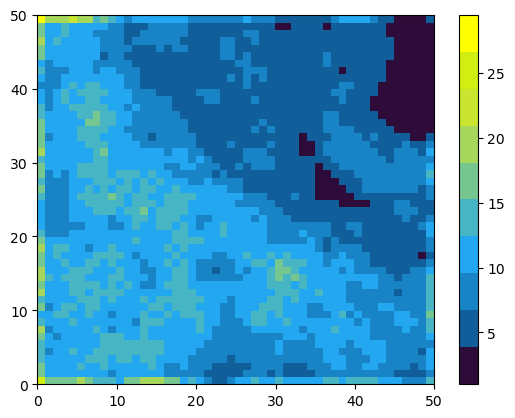

In [387]:
fig, ax = plt.subplots()

colors = ["#2F0B3A", "#115f9a", "#1984c5", "#22a7f0", "#48b5c4", "#76c68f", "#a6d75b", "#c9e52f", "#d0ee11", "yellow"]

# Create a ListedColormap
cmap = ListedColormap(colors)

#plt.pcolor(UM.T, cmap='bone_r')  # plotting the distance map as background
#plt.pcolor(UM.T, cmap='coolwarm')
plt.pcolor(1/UM.T, cmap=cmap)
plt.colorbar()

#markers = ['o', 's', 'D']
#colors = ['C0', 'C1', 'C2']
"""
for i in range(N):
    x = datas[i]
    w = get_winner_index(x,weights)
    #i_lab = labs[i]-1

    plt.plot(w[0]+.5, w[1]+.5)#, markers[i_lab], markerfacecolor='None')
        #,markeredgecolor=colors[i_lab], markersize=12, markeredgewidth=2)
"""
plt.show()


fig.savefig(pictures_path+'/all_dist_UM.png'
           , format='png'
           , dpi=100
           , bbox_inches='tight')
         

In [216]:
import nglview as nv

# Load the protein structure
structure = nv.FileStructure('visual.pdb')

# Create a visualization object
view = nv.NGLWidget(structure)

# Show the visualization
view


NGLWidget()

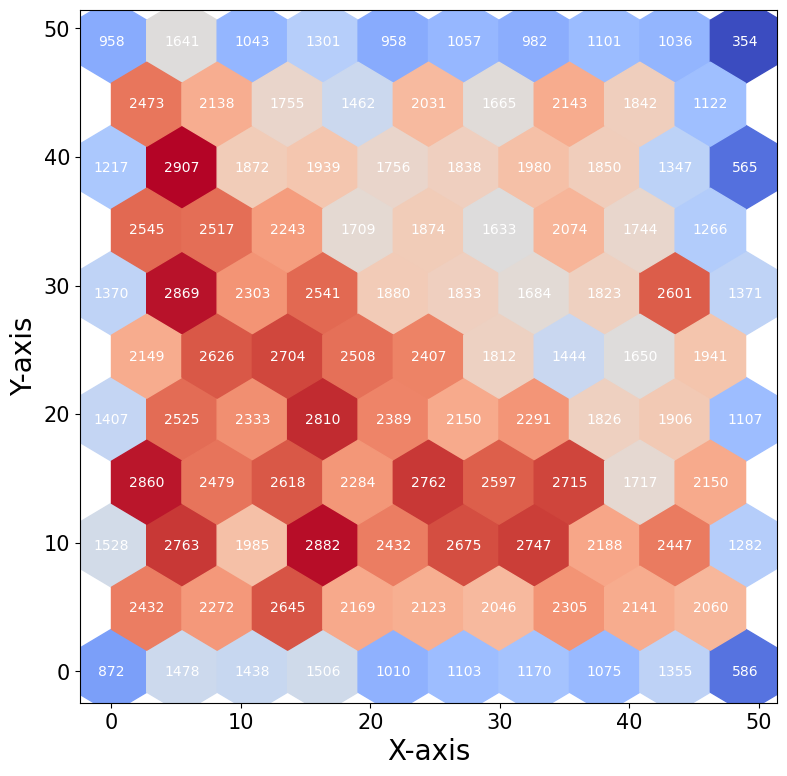

In [389]:
fontS = 20
tickS = 15

# 绘制蜂窝图
fig, ax = plt.subplots(figsize=(9, 9))

hb = plt.hexbin(xx, yy, gridsize=9, cmap='coolwarm')  # gridsize控制蜂窝的大小，cmap设置颜色映射

# 获取蜂窝的数值
counts = hb.get_array()



# 获取蜂窝的位置信息
x_centers = hb.get_offsets()[:, 0]
y_centers = hb.get_offsets()[:, 1]


# 在每个蜂窝的中心位置添加数值标签
for i, count in enumerate(counts):
    plt.text(x_centers[i], y_centers[i],int(count), ha='center', va='center', color='white')
    

#plt.colorbar(label='count in bin')  # 添加颜色条
plt.xticks(fontsize=tickS)
plt.yticks(fontsize=tickS)
plt.xlabel('X-axis',fontsize=fontS)
plt.ylabel('Y-axis',fontsize=fontS)
#plt.title('Hexbin Plot')
plt.show()


fig.savefig(pictures_path+'/all_dist_hexbin.png'
           , format='png'
           , dpi=100
           , bbox_inches='tight')
        

### Get centeriod points

In [189]:
### Get centeriod cell
max_points = max_points_of_interested(UM)
min_points = min_points_of_interested(UM)
print(max_points)
print(min_points)

[(2, 18), (1, 17), (1, 18), (48, 47), (47, 47), (0, 17), (2, 19), (2, 20), (48, 48), (1, 21)]
[(7, 0), (0, 0), (27, 11), (6, 0), (28, 19), (30, 20), (49, 23), (8, 0), (28, 20), (5, 0)]


In [155]:
### Inverse transform to initial points
points_collection = []
point = points[8]
point_ids = inverse_transform((29,20),x,y,index)

for id in point_ids:
    points_collection.append(data[id])
    
# Convert the list of arrays into a single 3D array
stacked_array = np.stack(points_collection)

# Calculate the mean along the first axis (which corresponds to the 'x' dimension)
center_point = np.mean(stacked_array, axis=0)
center_point
    

array([54.57210099, 34.99664877, 58.86378727])

In [156]:
### Bound state

### Inverse transform to initial points
points_collection = []
point = points[8]
point_ids = inverse_transform((27,12),x,y,index)

for id in point_ids:
    points_collection.append(data[id])
    
# Convert the list of arrays into a single 3D array
stacked_array = np.stack(points_collection)

# Calculate the mean along the first axis (which corresponds to the 'x' dimension)
center_point = np.mean(stacked_array, axis=0)
center_point

array([53.99793413, 35.49075838, 59.01430806])

In [150]:
### Inter1 state

# Convert the list of arrays into a single 3D array
stacked_array = np.stack(points_collection)

# Calculate the mean along the first axis (which corresponds to the 'x' dimension)
center_point = np.mean(stacked_array, axis=0)
center_point

array([59.06874857, 26.37214002, 62.29018859])

In [157]:
points_collection = []
point = points[8]
point_ids = inverse_transform((13,1),x,y,index)

for id in point_ids:
    points_collection.append(data[id])
    
# Convert the list of arrays into a single 3D array
stacked_array = np.stack(points_collection)

# Calculate the mean along the first axis (which corresponds to the 'x' dimension)
center_point = np.mean(stacked_array, axis=0)
center_point

array([53.70533644, 33.45011674, 60.38352792])

In [159]:
### Unbound state
points_collection = []
point = points[8]
point_ids = inverse_transform((1,47),x,y,index)

for id in point_ids:
    points_collection.append(data[id])
    
# Convert the list of arrays into a single 3D array
stacked_array = np.stack(points_collection)

# Calculate the mean along the first axis (which corresponds to the 'x' dimension)
center_point = np.mean(stacked_array, axis=0)
center_point

array([61.33644717, 22.14456737, 52.69234841])

In [160]:
### Unbound state
points_collection = []
point = points[8]
point_ids = inverse_transform((49,48),x,y,index)

for id in point_ids:
    points_collection.append(data[id])
    
# Convert the list of arrays into a single 3D array
stacked_array = np.stack(points_collection)

# Calculate the mean along the first axis (which corresponds to the 'x' dimension)
center_point = np.mean(stacked_array, axis=0)
center_point

array([48.50862239, 27.74695544, 49.21416246])

In [164]:
### Inter 3
points_collection = []
point = points[8]
point_ids = inverse_transform((43,3),x,y,index)

for id in point_ids:
    points_collection.append(data[id])
    
# Convert the list of arrays into a single 3D array
stacked_array = np.stack(points_collection)

# Calculate the mean along the first axis (which corresponds to the 'x' dimension)
center_point = np.mean(stacked_array, axis=0)
center_point

array([52.19702293, 33.84733655, 59.85705898])

### SOM was used to do cluster in the purpose of identify states in between bound and unbound;
### Hexbin plot was made, but we want to do futher cluster to make more clear states plot;
### Here we are going to use agglomerative hierarchical clustering (HCA)

In [217]:
conda install -c conda-forge scikit-learn

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0



## Package Plan ##

  environment location: /Users/xueguangpeng/anaconda3

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-1.3.0         |  py311h7aedaa7_1         8.8 MB
    ------------------------------------------------------------
                                           Total:         8.8 MB

The following packages will be UPDATED:

  scikit-learn                        1.3.0-py311h7aedaa7_0 --> 1.3.0-py311h7aedaa7_1 



                                                       

In [372]:
### Process UM for AHC

flatten_UM = []

for i in range(UM.shape[0]):
    for j in range(UM.shape[1]):
        flatten_UM.append([i,j,UM[i,j]])
        
flatten_UM = np.array(flatten_UM)        

/Users/xueguangpeng/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


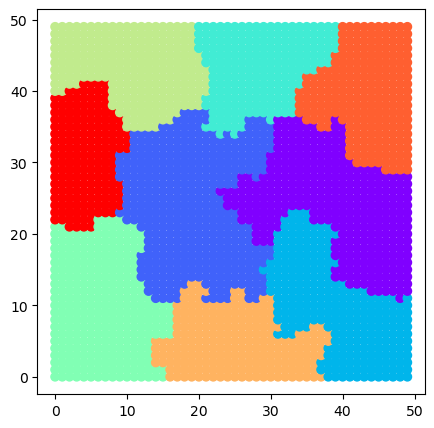

In [390]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering


# Perform Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='complete').fit(flatten_UM)

# Visualize the clustering results
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(flatten_UM[:, 0], flatten_UM[:, 1], c=clustering.labels_, cmap='rainbow')

#plt.xlabel('Feature 1')
#plt.ylabel('Feature 2')
#plt.title('Agglomerative Hierarchical Clustering')
#plt.colorbar(label='Cluster')
#plt.legend()
plt.show()


fig.savefig(pictures_path+'/all_dist_clusters.png'
           , format='png'
           , dpi=100
           , bbox_inches='tight')
           
         

In [293]:
len(clustering.labels_)

2500

In [375]:
### We are going to contruct of matrix which would contain the population of each neuron.

# Assuming you have two lists, each containing values from 0 to 49
x_lt = xx  # Replace [...] with your first list
y_lt = yy  # Replace [...] with your second list

# Create a matrix with dimensions (50, 50) initialized with zeros
population_matrix = np.zeros((50, 50))

# Increment the count at each point in the matrix based on the values from the lists
for i, j in zip(x_lt, y_lt):
    population_matrix[j, i] += 1  # Increment count at position (y, x)

# Print the resulting matrix
print(population_matrix)


[[ 90.  84.  74. ...  65.  46.  60.]
 [ 81.  78. 104. ...  63.  63.  50.]
 [ 86.  91.  82. ...  76.  61.  52.]
 ...
 [ 78.  95. 102. ...  22.  17.  62.]
 [ 96. 101. 103. ...  54.  13.  15.]
 [ 81.  93. 112. ...  27.  66.  78.]]


In [376]:
population_matrix.max()

140.0

In [377]:
population_matrix.sum()

199095.0

In [378]:
### Looks correct so far.
### We are then going to add label for each neuron.

array_cluster_label = clustering.labels_
matrix_cluster_label = array_cluster_label.reshape(50,50)
matrix_cluster_label

array([[4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5],
       ...,
       [2, 2, 2, ..., 7, 7, 7],
       [2, 2, 2, ..., 7, 7, 7],
       [2, 2, 2, ..., 7, 7, 7]])

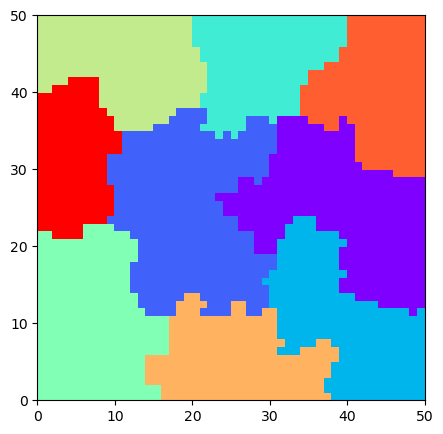

In [395]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.pcolor(matrix_cluster_label.T,cmap='rainbow')
#plt.colorbar()
fig.savefig(pictures_path+'/all_dist_clusters.png'
           , format='png'
           , dpi=100
           , bbox_inches='tight')

In [380]:
### Looks correct.
### Let us get the max neuron of each cluster

### First of all, we need to return indices of each cluster.
### Match the indices of population_matrix and find the max neuron

# Find the unique values in the matrix
unique_values = np.unique(matrix_cluster_label)

# Initialize a dictionary to store indices for each unique value
indices_dict = {}

# Iterate over unique values and find indices for each value
for value in unique_values:
    indices = np.where(matrix_cluster_label == value)
    indices_dict[value] = list(zip(indices[0], indices[1]))

# Print the dictionary containing indices for each unique value
for value, indices in indices_dict.items():
    print(f"Value {value}: {indices}")

Value 0: [(23, 26), (24, 24), (24, 25), (24, 26), (25, 24), (25, 25), (25, 26), (26, 22), (26, 23), (26, 24), (26, 25), (26, 26), (26, 27), (26, 28), (27, 22), (27, 23), (27, 24), (27, 25), (27, 26), (27, 27), (27, 28), (28, 19), (28, 20), (28, 21), (28, 22), (28, 23), (28, 24), (28, 25), (28, 26), (28, 27), (29, 19), (29, 20), (29, 21), (29, 22), (29, 23), (29, 24), (29, 25), (29, 26), (29, 27), (29, 28), (30, 19), (30, 20), (30, 21), (30, 22), (30, 23), (30, 24), (30, 25), (30, 26), (30, 27), (30, 28), (30, 29), (30, 30), (30, 31), (31, 21), (31, 22), (31, 23), (31, 24), (31, 25), (31, 26), (31, 27), (31, 28), (31, 29), (31, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (32, 23), (32, 24), (32, 25), (32, 26), (32, 27), (32, 28), (32, 29), (32, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (32, 36), (33, 24), (33, 25), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (33, 36), (34, 24), (34, 25), (34, 26), 

In [381]:
### We are going to print out the index of maximum neuron of each cluster

cluster_center_points_lt = []
for cluster,_ in indices_dict.items():
    population_count_lt = []

    for i in range(len(indices_dict[cluster])):
        index = indices_dict[cluster][i]
        population_count_lt.append(population_matrix[index[0],index[1]])
    ### Return the maximum element index
    maxlt_index = population_count_lt.index(max(population_count_lt))
    max_index = indices_dict[cluster][maxlt_index]
    cluster_center_points_lt.append(max_index)
    print(f'Cluster {cluster}: max index {max_index}')

Cluster 0: max index (34, 28)
Cluster 1: max index (15, 22)
Cluster 2: max index (38, 4)
Cluster 3: max index (27, 42)
Cluster 4: max index (10, 14)
Cluster 5: max index (14, 47)
Cluster 6: max index (17, 9)
Cluster 7: max index (42, 36)
Cluster 8: max index (8, 37)


In [382]:
### Inverse transform to initial points

for k,point in enumerate(cluster_center_points_lt):
    points_collection = []
    point_ids = inverse_transform(point,xx,yy,ori_index)
    for ids in point_ids:
        points_collection.append(data[ids])
    # Convert the list of arrays into a single 3D array
    stacked_array = np.stack(points_collection)

    # Calculate the mean along the first axis (which corresponds to the 'x' dimension)
    center_point = np.mean(stacked_array, axis=0)
    print(f'Cluster {k}: center point: {center_point[0:3]}')


Cluster 0: center point: [56.33797796 30.23493736 56.80341632]
Cluster 1: center point: [54.64558683 34.75721732 58.26046278]
Cluster 2: center point: [52.78462594 34.26648368 58.48187518]
Cluster 3: center point: [58.58296222 31.69568882 57.4287419 ]
Cluster 4: center point: [54.92286309 34.3639467  58.71152128]
Cluster 5: center point: [56.35129811 32.93503406 58.76543523]
Cluster 6: center point: [53.48041268 34.63289524 59.19143986]
Cluster 7: center point: [54.50511113 25.37422586 56.30439222]
Cluster 8: center point: [54.23487411 34.92413748 59.07583445]


In [384]:
### We are going to try to use the average coordinates of all points of the same cluster, 
### Rather than max neuron.

for value, indices in indices_dict.items():
    points_collection = []
    for point in indices:
        point_ids = inverse_transform(point,xx,yy,ori_index)
        for ids in point_ids:
            points_collection.append(data[ids])
    # Convert the list of arrays into a single 3D array
    stacked_array = np.stack(points_collection)            
    # Calculate the mean along the first axis (which corresponds to the 'x' dimension)
    center_point = np.mean(stacked_array, axis=0)
    print(f'Cluster {value}: center point: {center_point[0:3]}')    

Cluster 0: center point: [55.15596666 31.27616372 55.74641692]
Cluster 1: center point: [54.70629616 33.9325736  58.15691478]
Cluster 2: center point: [53.82299497 33.69682017 57.96836615]
Cluster 3: center point: [58.04347356 30.0228929  57.79816481]
Cluster 4: center point: [53.87382139 35.29291711 59.24591707]
Cluster 5: center point: [55.58714543 34.27058912 59.1695873 ]
Cluster 6: center point: [52.96012147 34.44771625 58.54548673]
Cluster 7: center point: [57.66350151 26.18501547 56.04195369]
Cluster 8: center point: [53.82668947 34.97813741 59.32484968]
